<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
#%pip install statsmodels

In [80]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt

from bayes import *

In [4]:
# datos

df=pd.read_csv('data/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


### Analisis Datos / Diseno Experimento

In [5]:
df.shape

(90189, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [ ]:
#H0 > p == p0
#H1 > p != p0

#variables dependientes: tasa de retención a 1 dia, tasa de renteción a 7 días 

#grupo de control: gate 30 
#grupo de tratamiento: gate 40

In [9]:
#assumimos que el tamaño de la muestra es suficiente para lograr el efecto esperado (bien como otros parametros, i.e., alpha y power)

### Transformacion 

#### Experimento 1 

In [15]:
#datos que me importan 

df1 = df.loc[:,['userid','version','retention_1']]
df1.shape

(90189, 3)

In [17]:
#aceso unico 

df1['userid'].value_counts().head(3)

userid
116        1
6632278    1
6658202    1
Name: count, dtype: int64

#### Experimento 2

In [16]:
df7 = df.loc[:,['userid','version','retention_7']]
df7.shape

(90189, 3)

In [ ]:
#aceso unico 

df1['userid'].value_counts().head(3)

### Muestreo


#### Experimento 1  

In [37]:
#control 
control1 = df1[df1['version'] == 'gate_30']
control1.shape 

(44700, 3)

In [38]:
control1['retention_1'].value_counts()

retention_1
False    24666
True     20034
Name: count, dtype: int64

In [39]:
#tratamiento 
tratamiento1= df1[df1['version'] == 'gate_40']
tratamiento1.shape 

(45489, 3)

In [40]:
tratamiento1['retention_1'].value_counts()

retention_1
False    25370
True     20119
Name: count, dtype: int64

#### Experimento 2

In [44]:
#control 
control7 = df7[df7['version'] == 'gate_30']
control7.shape 

(44700, 3)

In [43]:
control7['retention_7'].value_counts()

retention_7
False    36198
True      8502
Name: count, dtype: int64

In [45]:
#tratamiento 
tratamiento7= df7[df7['version'] == 'gate_40']
tratamiento7.shape 

(45489, 3)

### Testeo para retention 1

In [46]:
all_ctrl = control1.shape[0]
all_ctrl

44700

In [48]:
retention_ctrl = control1['retention_1'].value_counts()[1]
retention_ctrl

/var/folders/5p/mpbfgq4n4c15mzcjt_1kz83c0000gn/T/ipykernel_10556/2011387705.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  retention_ctrl = control1['retention_1'].value_counts()[1]


20034

In [50]:
all_trat = tratamiento1.shape[0] 
all_trat

45489

In [52]:
retention_trat = tratamiento1['retention_1'].value_counts()[1]
retention_trat 

/var/folders/5p/mpbfgq4n4c15mzcjt_1kz83c0000gn/T/ipykernel_10556/3885556412.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  retention_trat = tratamiento1['retention_1'].value_counts()[1]


20119

In [55]:
#tasa de retension 
RR_ctrl = retention_ctrl/all_ctrl
RR_trat = retention_trat/all_trat
f'Tasas retención: Control: {RR_ctrl}, Test: {RR_trat}'

'Tasas retención: Control: 0.4481879194630872, Test: 0.44228274967574577'

In [56]:
# a prioris (parametros de la funcion beta)

a_C, b_C = 1+retention_ctrl, 1+all_ctrl-retention_ctrl 

a_T, b_T = 1+retention_trat, 1+all_trat-retention_trat

beta_control = beta(a_C, b_C) #distribuicion beta de los dos parametros de control

beta_test = beta(a_T, b_T) #distribuicion beta de los parametros de test

In [57]:
#coincide con lo de arriba 

beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

In [78]:
x=np.linspace(0.425, 0.465, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

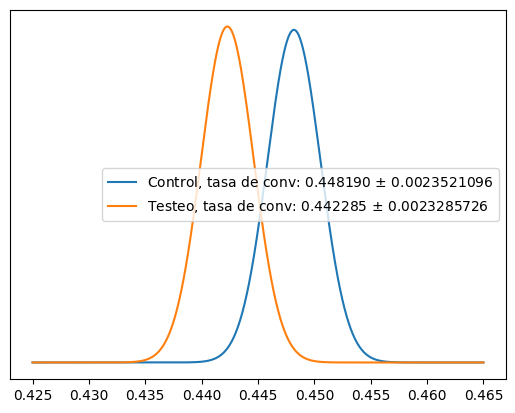

In [79]:
plot([beta_control, beta_test], ['Control', 'Testeo'])

In [84]:
#cuanto es mejor uno que otro?

salto1 = (beta_test.mean() - beta_control.mean())/beta_control.mean()

salto1

-0.013175098158249857

In [83]:
prob1=calc_prob(beta_test, beta_control)  

prob1

0.037206025180329845

In [85]:
'''El test aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto1*100, prob1*100)

'El test aumenta la tasa de conversion en un -1.32%, con una probabilidad del 3.72%'

### Testeo para retention 7



In [88]:
all_ctrl = control7.shape[0]
all_ctrl

44700

In [89]:
retention_ctrl = control7['retention_7'].value_counts()[1]
retention_ctrl

/var/folders/5p/mpbfgq4n4c15mzcjt_1kz83c0000gn/T/ipykernel_10556/1102951586.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  retention_ctrl = control7['retention_7'].value_counts()[1]


8502

In [90]:
all_trat = tratamiento7.shape[0] 
all_trat

45489

In [91]:
retention_trat = tratamiento7['retention_7'].value_counts()[1]
retention_trat 

/var/folders/5p/mpbfgq4n4c15mzcjt_1kz83c0000gn/T/ipykernel_10556/2161750621.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  retention_trat = tratamiento7['retention_7'].value_counts()[1]


8279

In [92]:
#tasa de retension 
RR_ctrl = retention_ctrl/all_ctrl
RR_trat = retention_trat/all_trat
f'Tasas retención: Control: {RR_ctrl}, Test: {RR_trat}'

'Tasas retención: Control: 0.19020134228187918, Test: 0.18200004396667327'

In [93]:
# a prioris (parametros de la funcion beta)

a_C, b_C = 1+retention_ctrl, 1+all_ctrl-retention_ctrl 

a_T, b_T = 1+retention_trat, 1+all_trat-retention_trat

beta_control = beta(a_C, b_C) #distribuicion beta de los dos parametros de control

beta_test = beta(a_T, b_T) #distribuicion beta de los parametros de test

In [94]:
#coincide con lo de arriba 

beta_control.mean(), beta_test.mean()

(0.19021520289919913, 0.18201402475214878)

In [97]:
x=np.linspace(0.17, 0.20, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

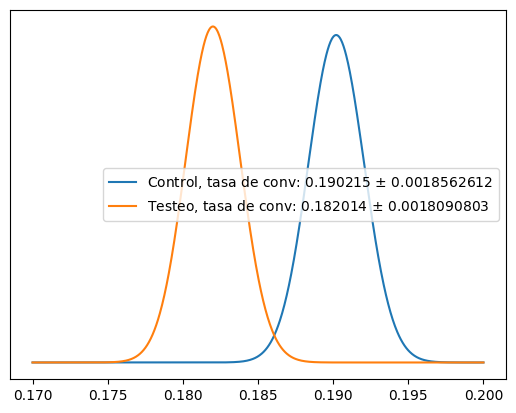

In [98]:
plot([beta_control, beta_test], ['Control', 'Testeo'])

In [99]:
#cuanto es mejor uno que otro?

salto7 = (beta_test.mean() - beta_control.mean())/beta_control.mean()

salto7

-0.04311526114658881

In [100]:
prob7=calc_prob(beta_test, beta_control)  

prob7

0.0007773386645759051

### Conclusiones

#### Experimento 1

In [87]:
'''El test aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto1*100, prob1*100)

'El test aumenta la tasa de conversion en un -1.32%, con una probabilidad del 3.72%'

#### Experimento 7

In [101]:
'''El test aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto7*100, prob7*100)

'El test aumenta la tasa de conversion en un -4.31%, con una probabilidad del 0.08%'